# Tutorial 3: AutoML


In this tutorial, we will use AutoML to select the best suited model for our task.

## Demo Preparation

We will simulate a local ES index for this example. The dataset used is [User Churn dataset](https://square.github.io/pysurvival/tutorials/churn.html).

In [1]:
!pip install pysurvival &> /dev/null

import numpy as np
import eland as ed
from pysurvival.datasets import Dataset
import warnings
warnings.filterwarnings('ignore')

# Load dataset
raw_dataset = Dataset('churn').load() 

time_column = 'months_active'
event_column = 'churned'

features = np.setdiff1d(raw_dataset.columns, [time_column, event_column] ).tolist()

# Upload dataframe to ES 
ed.pandas_to_eland(raw_dataset,
                   es_client='localhost',
                   es_dest_index='churn-prediction',
                   es_if_exists='replace',
                   es_dropna=True,
                   es_refresh=True,
                  ) 

,articles_viewed,churned,company_size,csat_score,marketing_emails_clicked,minutes_customer_support,months_active,product_accounting,product_data_storage,product_payroll,product_travel_expense,smartphone_notifications_viewed,social_media_ads_viewed,us_region
0,4,1.0,10-50,9,14,8.3,3.0,No,2048,Active,Free-Trial,0,1,West North Central
1,4,1.0,100-250,9,12,0.0,2.0,Active,2048,Free-Trial,Free-Trial,2,1,South Atlantic
2,3,0.0,100-250,9,17,0.0,7.0,Active,2048,Active,Active,2,1,East South Central
3,0,1.0,50-100,10,14,0.0,8.0,No,500,Free-Trial,Active,0,0,East South Central
4,5,0.0,50-100,8,17,0.0,7.0,Free-Trial,5120,Active,Free-Trial,0,0,East North Central
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,3,0.0,50-100,9,19,0.4,8.0,Free-Trial,1024,Active,Free-Trial,0,1,Mountain
1996,3,1.0,50-100,7,15,0.0,2.0,Active,1024,Active,Free-Trial,0,0,Middle Atlantic
1997,5,1.0,10-50,8,15,5.9,1.0,Active,500,Active,Free-Trial,0,0,West North Central
1998,6,1.0,100-250,10,15,3.3,3.0,Active,500,No,Free-Trial,1,1,Pacific


## Data Backend



In [2]:
from elastic_surv.dataset import ESDataset

dataset = ESDataset(
    es_index_pattern = 'churn-prediction',
    time_column = 'months_active',
    event_column = 'churned',
    es_client = "localhost",
)

## Search the model

In [3]:
from elastic_surv.optimizer import HyperbandOptimizer

opt = HyperbandOptimizer(max_iter = 27)

# this might take a while
selected_model = opt.select_model(dataset)

In [4]:
selected_model.name()

'deephit'

In [7]:
selected_model.train(dataset)

selected_model.score(dataset)

{'c_index': 0.814025351579744, 'brier_score': 0.04045032884707591}

## Prediction

We can evaluate the survival function for new data.

The output of the `predict` call is a `[time_horizons x number_of_testcases]` matrix.

For each row and for each time horizon, the matrix contains the probability of "survival" at that timestamp for that subject.
The 'survival' is defined by the dataset outcome - user churn, in our example.


In [10]:
import torch

test_ds = dataset.copy().test()
test_dl = test_ds.dataloader(batch_size=len(test_ds))
x_test, y_test = next(iter(test_dl))
 

predictions = selected_model.predict(x_test)

predictions

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0.000000,0.999978,0.999702,0.999270,0.998866,1.000000,0.999581,1.000000e+00,0.999987,0.999421,0.998807,...,0.999798,0.999999,0.999992,0.999995,1.000000,0.999849,0.999994,0.999894,0.999981,0.999979
0.133333,0.999975,0.999604,0.998820,0.995607,0.968447,0.979330,9.653193e-01,0.977331,0.991156,0.994245,...,0.999642,0.973798,0.977352,0.999995,0.979057,0.999830,0.976780,0.981302,0.976895,0.978194
0.266667,0.999972,0.999506,0.998369,0.992348,0.936894,0.959080,9.306387e-01,0.954675,0.982892,0.989683,...,0.999487,0.947597,0.954712,0.999995,0.958115,0.999812,0.953567,0.962710,0.953809,0.956409
0.400000,0.999970,0.999407,0.997919,0.989088,0.905340,0.938830,8.959580e-01,0.932018,0.974628,0.985121,...,0.999331,0.921397,0.932072,0.999995,0.937173,0.999793,0.930353,0.944118,0.930723,0.934624
0.533333,0.999967,0.999309,0.997468,0.985829,0.873787,0.918579,8.612773e-01,0.909362,0.966363,0.980559,...,0.999176,0.895196,0.909432,0.999995,0.916231,0.999775,0.907140,0.925526,0.907637,0.912839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11.466667,0.372855,0.188198,0.132035,0.082205,0.000001,0.026510,1.788139e-07,0.002070,0.037629,0.074201,...,0.322153,0.000188,0.000923,0.369256,0.000091,0.248665,0.000694,0.008240,0.001740,0.001842
11.600000,0.280864,0.145943,0.104766,0.072433,0.000001,0.026268,1.788139e-07,0.002070,0.036722,0.066853,...,0.254376,0.000188,0.000923,0.276983,0.000091,0.188768,0.000694,0.008225,0.001739,0.001841
11.733333,0.188874,0.103688,0.077497,0.062662,0.000001,0.026026,1.788139e-07,0.002069,0.035816,0.059506,...,0.186598,0.000188,0.000923,0.184710,0.000091,0.128871,0.000694,0.008210,0.001739,0.001841
11.866667,0.096884,0.061433,0.050229,0.052891,0.000001,0.025784,1.788139e-07,0.002069,0.034909,0.052158,...,0.118821,0.000188,0.000922,0.092437,0.000091,0.068974,0.000694,0.008196,0.001738,0.001840


## Plot the average survival probability for the test population

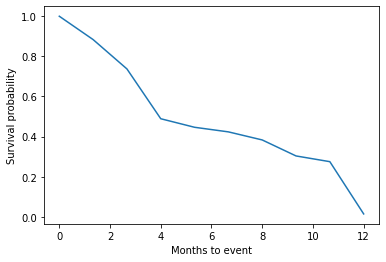

In [11]:
!pip install seaborn &> /dev/null

import seaborn as sns
import matplotlib.pyplot as plt

avg_surv = np.mean(predictions, axis = 1)

ax = sns.lineplot(data=avg_surv)
ax.set(xlabel='Months to event', ylabel='Survival probability')

plt.show()